# Heatmap

In [43]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
DATA_DIR = "../input/commonlit-evaluate-student-summaries/"
DATA_DIR = "../data/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
train = pd.read_csv(DATA_DIR + "summaries_train.csv")

In [12]:
trfeat = pd.read_parquet("tmp_train_preprocessed.parquet")

In [13]:
feat = trfeat.drop(["prompt_id", "text", "content", "wording", "fixed_summary_text", "prompt_question", "prompt_title", "fold", "prompt_text", 
             "_llama2_summ", "full_prompt", "short_prompt", "bleurt", "bleurt_ref", "bleurt_ref_fs",
             'ap_bleurt', 'ap_bleurt_fs', 'ap_bleurt_ref',
             'ap_bleurt_ref_fs'], 
            axis=1)

In [14]:
train = train.merge(feat, on="student_id", how="left")

In [7]:
train.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'summary_length', 'splling_err_num', 'prompt_length', 'length_ratio',
       'word_overlap_count', 'bigram_overlap_count', 'bigram_overlap_ratio',
       'trigram_overlap_count', 'trigram_overlap_ratio', 'quotes_count',
       'word_overlap_ratio', 'perplexity', 'log_perplexity'],
      dtype='object')

In [8]:
train.head(2)

,student_id,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,word_overlap_ratio,perplexity,log_perplexity
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,5,660,0.096970,14,4,0.063492,0,0.000000,0,0.218750,34572.480469,10.450813
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,2,1076,0.050186,18,22,0.415094,10,0.192308,0,0.333333,41174.566406,10.625576


In [7]:
train["n_sum_sent"] = train.text.apply(lambda x: len(sent_tokenize(x, language='english')))

In [11]:
prompts_train["n_sent"] =  prompts_train.prompt_text.apply(lambda x: len(sent_tokenize(x, language='english')))

In [14]:
train = train.merge(prompts_train[["prompt_id", "n_sent"]], on="prompt_id", how="left")

In [15]:
train["ratio_sent_size"] = train.n_sum_sent / train.n_sent

In [12]:
prompts_train[["prompt_id", "n_sent"]]

,prompt_id,n_sent
0,39c16e,25
1,3b9047,44
2,814d6b,25
3,ebad26,23


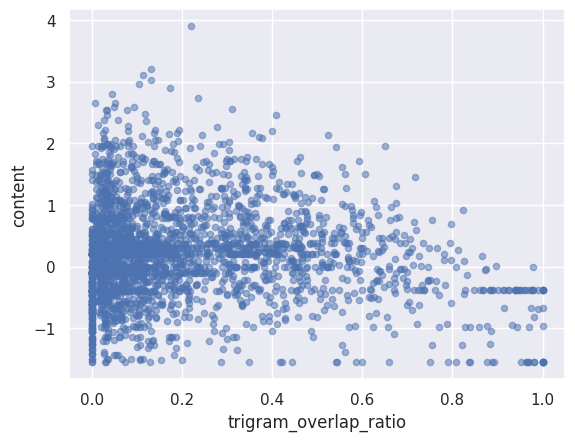

In [44]:
train[train.ratio_sent_size.between(0.1,0.2)].plot.scatter(x="trigram_overlap_ratio", y="content", alpha=0.5);

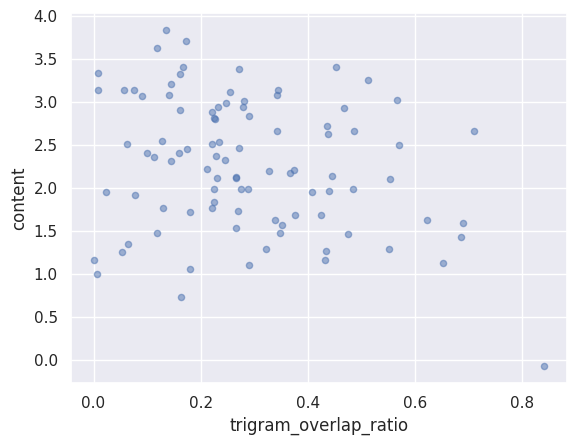

In [45]:
train[train.ratio_sent_size.between(0.4,0.5)].plot.scatter(x="trigram_overlap_ratio", y="content", alpha=0.5);

In [54]:
pt = pd.pivot_table(train, index="prompt_id", columns="n_sum_sent", values="content", aggfunc="mean")

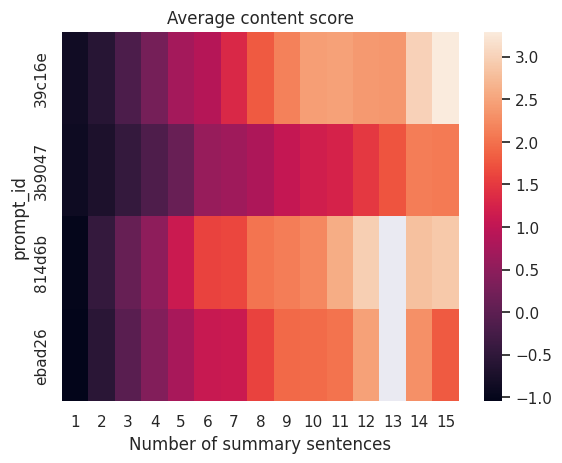

In [55]:
ax = sns.heatmap(pt);
ax.set_title("Average content score")
ax.set_xlabel("Number of summary sentences");

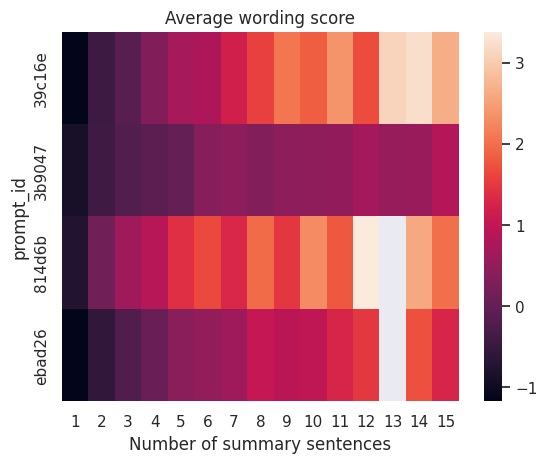

In [56]:
pt = pd.pivot_table(train, index="prompt_id", columns="n_sum_sent", values="wording", aggfunc="mean")

ax = sns.heatmap(pt);
ax.set_title("Average wording score")
ax.set_xlabel("Number of summary sentences");

In [46]:
train.text.values[0]

'The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

## Heatmap

Size Ratio Slider, Bleurt Y, CosSim X, Content color

In [17]:
cols = ["prompt_id", "content", "wording", "length_ratio", "bigram_overlap_ratio",
       "trigram_overlap_ratio", "word_overlap_ratio", "bleurt_fs"]
dx = train[cols].copy()

In [25]:
dx["log_len_ratio"] = np.log(dx.length_ratio)

In [30]:
dx.loc[dx.length_ratio.gt(0.6), "length_ratio"] = 0.6

In [62]:
bcut, bcc =  pd.cut(dx.bleurt_fs, 15, retbins=True)
wcut, wcc = pd.cut(dx.word_overlap_ratio, 15, retbins=True)

In [71]:
bcc_map = {v:idx for idx,v in enumerate(np.round(bcc, 2))}
wcc_map = {v:idx for idx,v in enumerate(np.round(wcc, 2))}

In [73]:
dx["bleurt_c"] = [bcc_map[np.round(v.right,2)] for v in bcut]
dx["word_overlap_ratio_c"] = [wcc_map[np.round(v.left,2)] for v in wcut]

In [55]:
pt = pd.pivot_table(dx, index="bleurt_c", columns="word_overlap_ratio_c", 
                        values="content", aggfunc="mean")
pt.min().min(), pt.max().max()

(-1.54716321678788, 3.2653137931332754)

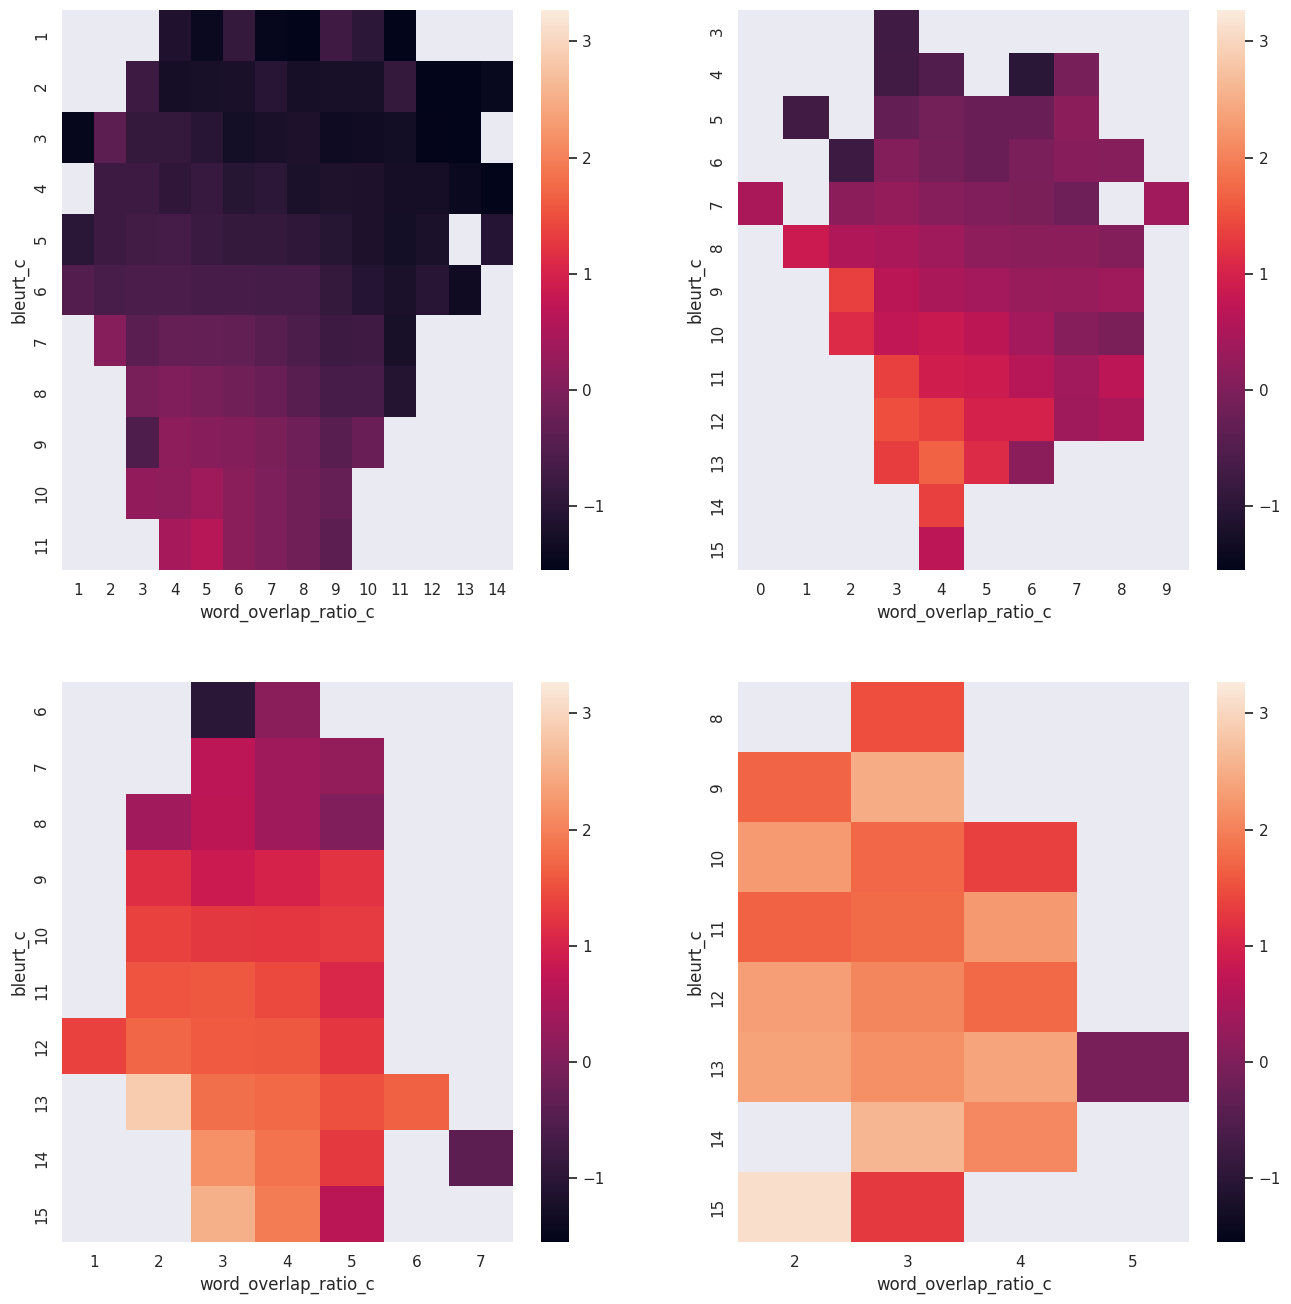

In [74]:
_, ax = plt.subplots(2,2, figsize=(16,16)) 
ax = ax.flatten()
for idx, rng in enumerate([(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4)]):
    pt = pd.pivot_table(dx[dx.length_ratio.between(*rng)], index="bleurt_c", columns="word_overlap_ratio_c", 
                        values="content", aggfunc="mean")
    sns.heatmap(pt, vmin=-1.548, vmax=3.27, ax=ax[idx])